In [1]:
from tensorflow.keras import layers
from tensorflow import keras

# 함수형 API를 사용한 모델

In [3]:
# 입력 클래스 객체 생성(심볼릭텐서)
inputs=keras.Input(shape=(3,),name='input')
# 첫번째 층 생성(새로운 심볼릭텐서)
features=layers.Dense(64,activation='relu')(inputs)
# 최종 출력을 얻어 입력과 출력을 모델 클래스에 전달하여 모델 객체 생성
outputs=layers.Dense(10,activation='softmax')(features)
model=keras.Model(inputs=inputs,outputs=outputs)

In [4]:
# 모델의 결과
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


## 다중입력, 다중출력 모델
대부분 딥러닝 모델은 리스트와 같은 형태가 아님. 입력이 여러개거나 출력이 여러개인 모델에서 함수형 API모델이 빛을 발함.  
3개의 입력을 가지는 모델을 예시로 사용
- 이슈 티켓의 제목(텍스트)
- 이슈 티켓의 텍스트 본문(텍스트)
- 사용자가 추가한 태그(범주형 입력,원핫인코딩으로 가정)

In [6]:
voca_size=10000
num_tags=100
num_dpart=4

### 모델 입력층 생성

In [31]:
title=keras.Input(shape=(voca_size,),name='title')
text_body=keras.Input(shape=(voca_size,),name='text_body')
tags=keras.Input(shape=(num_tags,),name='tags')

In [32]:
title

<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>

In [33]:
text_body

<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>

In [34]:
tags

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>

### 모델 입력 특성 결합

In [35]:
features=layers.Concatenate()([title,text_body,tags])
features

<KerasTensor: shape=(None, 20100) dtype=float32 (created by layer 'concatenate_2')>

In [36]:
features_layers=layers.Dense(64,activation='relu')(features)
features_layers

<KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'dense_5')>

In [37]:
prior=layers.Dense(1,activation='sigmoid',name='prior')(features_layers)
depart=layers.Dense(num_dpart,activation='softmax',name='depart')(features_layers)

In [38]:
model=keras.Model(inputs=[title,text_body,tags],
                 outputs=[prior,depart])

In [39]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title (InputLayer)             [(None, 10000)]      0           []                               
                                                                                                  
 text_body (InputLayer)         [(None, 10000)]      0           []                               
                                                                                                  
 tags (InputLayer)              [(None, 100)]        0           []                               
                                                                                                  
 concatenate_2 (Concatenate)    (None, 20100)        0           ['title[0][0]',                  
                                                                  'text_body[0][0]',        

In [40]:
import numpy as np

num_samples=1280

title_data=np.random.randint(0,2,size=(num_samples,voca_size))
text_body_data=np.random.randint(0,2,size=(num_samples,voca_size))
tags_data=np.random.randint(0,2,size=(num_samples,num_tags))

In [41]:
prior_data=np.random.random(size=(num_samples,1))
depart_data=np.random.randint(0,2,size=(num_samples,num_dpart))

In [42]:
model.compile(optimizer='rmsprop',
             loss=['mean_squared_error','categorical_crossentropy'],
             metrics=['mean_absolute_error','accuracy'])
model.fit([title_data,text_body_data,tags_data],
         [prior_data,depart_data],
         epochs=1)
model.evaluate([title_data,text_body_data,tags_data],
         [prior_data,depart_data])

40/40 [==============================] - 1s 10ms/step - loss: 13.7637 - prior_loss: 0.3306 - depart_loss: 13.4331 - prior_mean_absolute_error: 0.4999 - prior_accuracy: 0.0000e+00 - depart_mean_absolute_error: 0.4689 - depart_accuracy: 0.2852


[13.763704299926758,
 0.33064624667167664,
 13.43305778503418,
 0.49987921118736267,
 0.0,
 0.46892040967941284,
 0.28515625]

In [43]:
prior_preds,depart_preds=model.predict([title_data,text_body_data,tags_data])

40/40 [==============================] - 1s 9ms/step


## 함수형 API 장점 : 층 연결 구조 활용

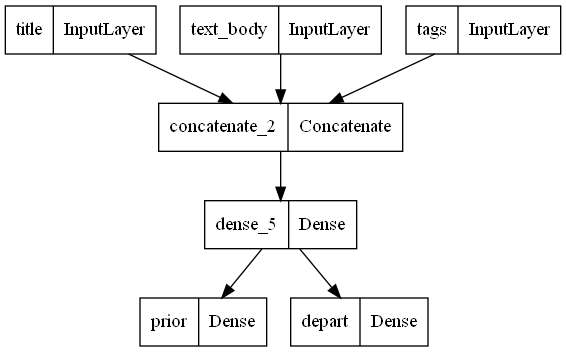

In [44]:
keras.utils.plot_model(model,'ticket_classifier.png')

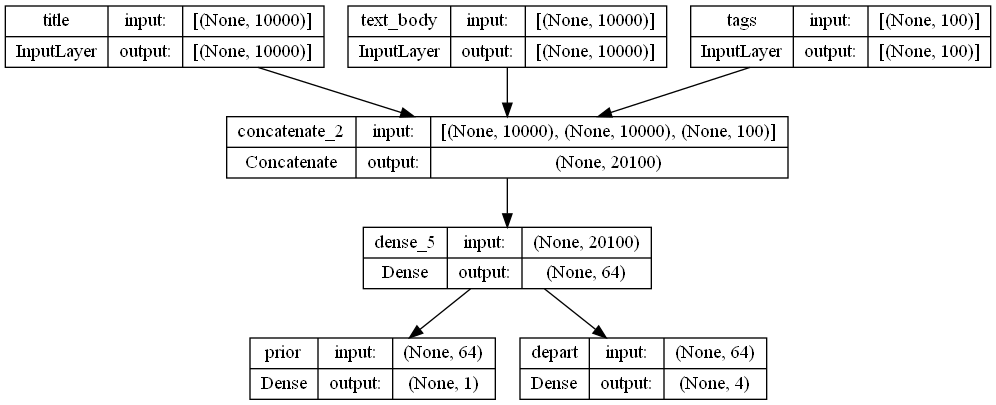

In [45]:
keras.utils.plot_model(model,'ticket_classifier_info.png',show_shapes=True)

### 함수형 모델의 층 출력

In [46]:
model.layers

In [47]:
model.layers[3].input

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

In [48]:
model.layers[3].output

<KerasTensor: shape=(None, 20100) dtype=float32 (created by layer 'concatenate_2')>

### 특성 추출을 통한 중간 특성 재사용

In [52]:
features=model.layers[4].output
dif_model=layers.Dense(3,activation='softmax',name='dif_model')(features)
new_model=keras.Model(inputs=[title,text_body,tags],
                     outputs=[prior,depart,dif_model])

In [55]:
new_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title (InputLayer)             [(None, 10000)]      0           []                               
                                                                                                  
 text_body (InputLayer)         [(None, 10000)]      0           []                               
                                                                                                  
 tags (InputLayer)              [(None, 100)]        0           []                               
                                                                                                  
 concatenate_2 (Concatenate)    (None, 20100)        0           ['title[0][0]',                  
                                                                  'text_body[0][0]',        

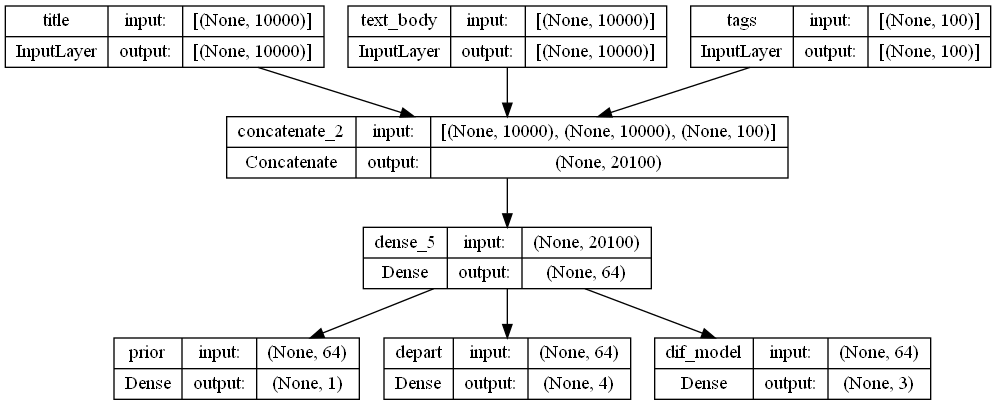

In [54]:
keras.utils.plot_model(new_model,'updated_ticket_classifier.png',show_shapes=True)